In [5]:
import numpy as np
import matplotlib.pyplot as plt


from larch.io import read_ascii
from larch.fitting import param, guess, param_group
from larch.xafs import (
    autobk,
    feffpath,
    feffit_transform,
    feffit_dataset,
    feffit,
    feffit_report,
    path2chi,
)
from larch.wxlib.xafsplots import plot_chifit
from larch import Group
from larch.xafs import pre_edge, autobk, xftf, xftr
from larch.io import read_ascii

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import random
import pandas as pd

In [6]:
# Utilities


def normalize_data(data, feature_range=(0, 1)):
    """
    Normalize the data to the specified feature range.

    Parameters:
    data (np.ndarray): The data to be normalized.
    feature_range (tuple): The desired range of transformed data.

    Returns:
    np.ndarray: Normalized data.
    dict: Dictionary containing the min and max values for each feature.
    """
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    scale = feature_range[1] - feature_range[0]
    normalized_data = feature_range[0] + (data - min_val) / (max_val - min_val) * scale

    norm_params = {"min": min_val, "max": max_val}

    return normalized_data, norm_params


def denormalize_data(normalized_data, norm_params, feature_range=(0, 1)):
    """
    Denormalize the data from the specified feature range to the original range.

    Parameters:
    normalized_data (np.ndarray): The data to be denormalized.
    norm_params (dict): Dictionary containing the min and max values for each feature.
    feature_range (tuple): The range of transformed data used during normalization.

    Returns:
    np.ndarray: Denormalized data.
    """
    min_val = norm_params["min"]
    max_val = norm_params["max"]
    scale = feature_range[1] - feature_range[0]
    denormalized_data = ((normalized_data - feature_range[0]) / scale) * (
        max_val - min_val
    ) + min_val

    return denormalized_data


def interpolate_spectrum(original_k, original_spectrum, target_k):
    """
    Interpolate the original spectrum onto the target energy mesh.

    Parameters:
    original_k (np.ndarray): The original energy mesh.
    original_spectrum (np.ndarray): The original spectrum values.
    target_k (np.ndarray): The target energy mesh.

    Returns:
    np.ndarray: Interpolated spectrum values on the target energy mesh.
    """
    interpolated_spectrum = np.interp(target_k, original_k, original_spectrum)
    return interpolated_spectrum

In [7]:
# create training data


class synthetic_spectrum:
    def __init__(
        self,
        feff_path_file,
        path_parameters=None,
        param_ranges=None,
        training_mode=False,
        num_examples=1,
        spectrum_noise=False,
        noise_range=(0, 0.01),
        k_range=(2.5, 12.5),
        seed=None,
    ):
        self.training_mode = training_mode
        self.num_examples = num_examples
        self.spectra = []
        self.parameters = []
        self.k = None
        self.k2chi = None
        self.spectrum_noise = spectrum_noise
        self.noise_range = noise_range
        self.k_range = k_range
        self.k_grid = np.linspace(k_range[0], k_range[1], num=100)

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        if self.training_mode:
            self.generate_training_examples(feff_path_file, param_ranges)
        else:
            self.generate_spectrum(feff_path_file, path_parameters, param_ranges)

    def generate_spectrum(
        self, feff_path_file, path_parameters=None, param_ranges=None
    ):
        path1 = feffpath(feff_path_file)

        if param_ranges:
            path_parameters = [
                random.uniform(param_ranges[key][0], param_ranges[key][1])
                for key in ["s02", "degen", "deltar", "sigma2", "e0"]
            ]

        if path_parameters:
            path1.s02 = path_parameters[0]
            path1.degen = path_parameters[1]
            path1.A = path1.s02 * path1.degen
            path1.deltar = path_parameters[2]
            path1.sigma2 = path_parameters[3]
            path1.e0 = path_parameters[4]

        path2chi(path1)

        if self.k is None:
            self.k = path1.k

        self.k2chi = path1.chi * path1.k**2

        if self.spectrum_noise:
            noise_level = random.uniform(self.noise_range[0], self.noise_range[1])
            noise = np.random.normal(0, noise_level, len(self.k2chi))
            self.k2chi += noise

        return path1.s02 * path1.degen, path1.deltar, path1.sigma2, path1.e0
        # return path1.s02 * path1.degen, path1.s02, path1.degen, path1.deltar, path1.sigma2, path1.e0

    def generate_training_examples(self, feff_path_file, param_ranges):
        for _ in range(self.num_examples):
            spectrum = self.generate_spectrum(feff_path_file, param_ranges=param_ranges)
            interpolated_spectrum = self.interpolate_spectrum(
                self.k, self.k2chi, self.k_grid
            )
            self.spectra.append(interpolated_spectrum)
            self.parameters.append(spectrum)

        self.spectra = np.array(self.spectra)
        self.parameters = np.array(self.parameters)

    def interpolate_spectrum(self, original_k, original_spectrum, target_k):
        """
        Interpolate the original spectrum onto the target k-grid.

        Parameters:
        original_k (np.ndarray): The original k-grid.
        original_spectrum (np.ndarray): The original spectrum values.
        target_k (np.ndarray): The target k-grid.

        Returns:
        np.ndarray: Interpolated spectrum values on the target k-grid.
        """
        interpolated_spectrum = np.interp(target_k, original_k, original_spectrum)
        return interpolated_spectrum

    def plot(self):
        if not self.training_mode:
            plt.plot(self.k, self.k2chi, label=r"$\sigma^2 = 0$")
            plt.xlabel(r" $ k \rm\, (\AA^{-1})$")
            plt.ylabel(r"$ k^2\chi(k)$")
            plt.legend()
            plt.show()
        else:
            print("Training mode is active. No plot available.")

    def get_training_data(self):
        if self.training_mode:
            return self.spectra, self.parameters
        else:
            print("Training mode is not active. No training data available.")

    def save_training_data(
        self, filename_spectra="spectra.csv", filename_parameters="parameters.csv"
    ):
        if self.training_mode:
            spectra_df = pd.DataFrame(self.spectra)
            # parameters_df = pd.DataFrame(self.parameters, columns=['A', 'S02', 'degen', 'deltar', 'sigma2', 'e0'])
            parameters_df = pd.DataFrame(
                self.parameters, columns=["A", "deltar", "sigma2", "e0"]
            )
            spectra_df.to_csv(filename_spectra, index=False)
            parameters_df.to_csv(filename_parameters, index=False)
            print(f"Spectra data saved to {filename_spectra}")
            print(f"Parameters data saved to {filename_parameters}")
        else:
            print("Training mode is not active. No data to save.")

In [8]:
fname = "/home/ryuichi/python/NN_EXAFS/data/Pt/01_predata/feff.inp/feff0001.dat"
param_ranges = {
    "s02": (0.75, 1.2),
    "degen": (4, 13),
    "deltar": (-0.2, 0.2),
    "sigma2": (0.001, 0.02),
    "e0": (-10, 10),
}

seed = 42  # Set the seed for reproducibility

# Generate training examples with noise
Synthetic_Generator = synthetic_spectrum(
    fname,
    param_ranges=param_ranges,
    training_mode=True,
    num_examples=10000,
    spectrum_noise=True,
    noise_range=(0, 0.1),
)
spectra, parameters = Synthetic_Generator.get_training_data()
Synthetic_Generator.save_training_data(
    filename_spectra="data/spectra_a.csv", filename_parameters="data/parameters_a.csv"
)

Spectra data saved to data/spectra_a.csv
Parameters data saved to data/parameters_a.csv


In [10]:
normalized_spectra, norm_spectra_params = normalize_data(spectra)
normalized_parameters, norm_parameters_params = normalize_data(parameters)

# Convert NumPy arrays to PyTorch tensors
spectra_tensor = torch.tensor(spectra, dtype=torch.float32)
parameters_tensor = torch.tensor(normalized_parameters, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(spectra_tensor, parameters_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Example usage of the DataLoader in a training loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

In [14]:
device

device(type='cuda')

In [15]:
# Define your model
class MLP(nn.Module):
    def __init__(self, input_size=100, hidden_size=100, output_size=4):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [16]:
# Instantiate the model, loss function, and optimizer
model = MLP().to(device)
criterion = nn.MSELoss()  # Assuming a regression problem
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10000
best_val_loss = float("inf")
train_losses = []
val_losses = []


try:
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_x.pth")

except KeyboardInterrupt:
    print("Training interrupted. Saving the best model so far...")
    torch.save(model.state_dict(), "best_model_x.pth")

Epoch [1/10000], Train Loss: 0.1371, Val Loss: 0.0618
Epoch [2/10000], Train Loss: 0.0379, Val Loss: 0.0257
Epoch [3/10000], Train Loss: 0.0209, Val Loss: 0.0176
Epoch [4/10000], Train Loss: 0.0150, Val Loss: 0.0134
Epoch [5/10000], Train Loss: 0.0114, Val Loss: 0.0104
Epoch [6/10000], Train Loss: 0.0089, Val Loss: 0.0084
Epoch [7/10000], Train Loss: 0.0072, Val Loss: 0.0068
Epoch [8/10000], Train Loss: 0.0060, Val Loss: 0.0058
Epoch [9/10000], Train Loss: 0.0051, Val Loss: 0.0050
Epoch [10/10000], Train Loss: 0.0045, Val Loss: 0.0045
Epoch [11/10000], Train Loss: 0.0040, Val Loss: 0.0041
Epoch [12/10000], Train Loss: 0.0037, Val Loss: 0.0038
Epoch [13/10000], Train Loss: 0.0033, Val Loss: 0.0036
Epoch [14/10000], Train Loss: 0.0031, Val Loss: 0.0033
Epoch [15/10000], Train Loss: 0.0029, Val Loss: 0.0031
Epoch [16/10000], Train Loss: 0.0027, Val Loss: 0.0028
Epoch [17/10000], Train Loss: 0.0025, Val Loss: 0.0027
Epoch [18/10000], Train Loss: 0.0023, Val Loss: 0.0025
Epoch [19/10000], T

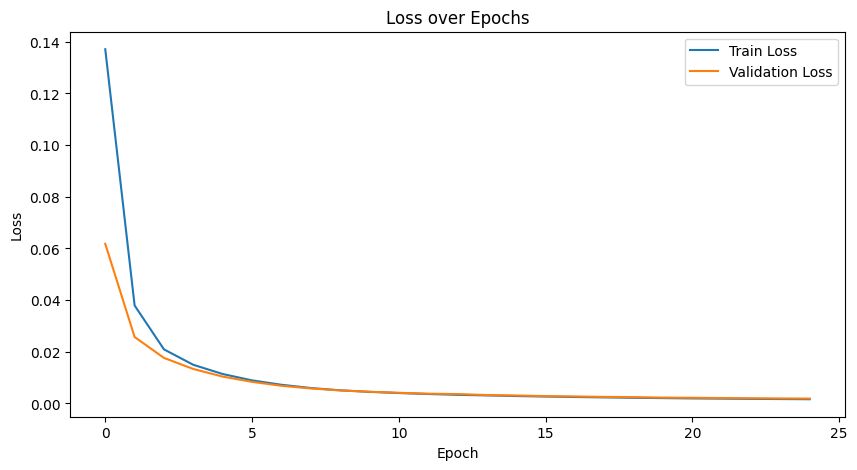

In [17]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

In [18]:
# Load the best model
model.load_state_dict(torch.load("best_model_x.pth"))

<All keys matched successfully>

In [19]:
parameter_name_dict = {0: "A", 1: "deltar", 2: "sigma2", 3: "e0"}

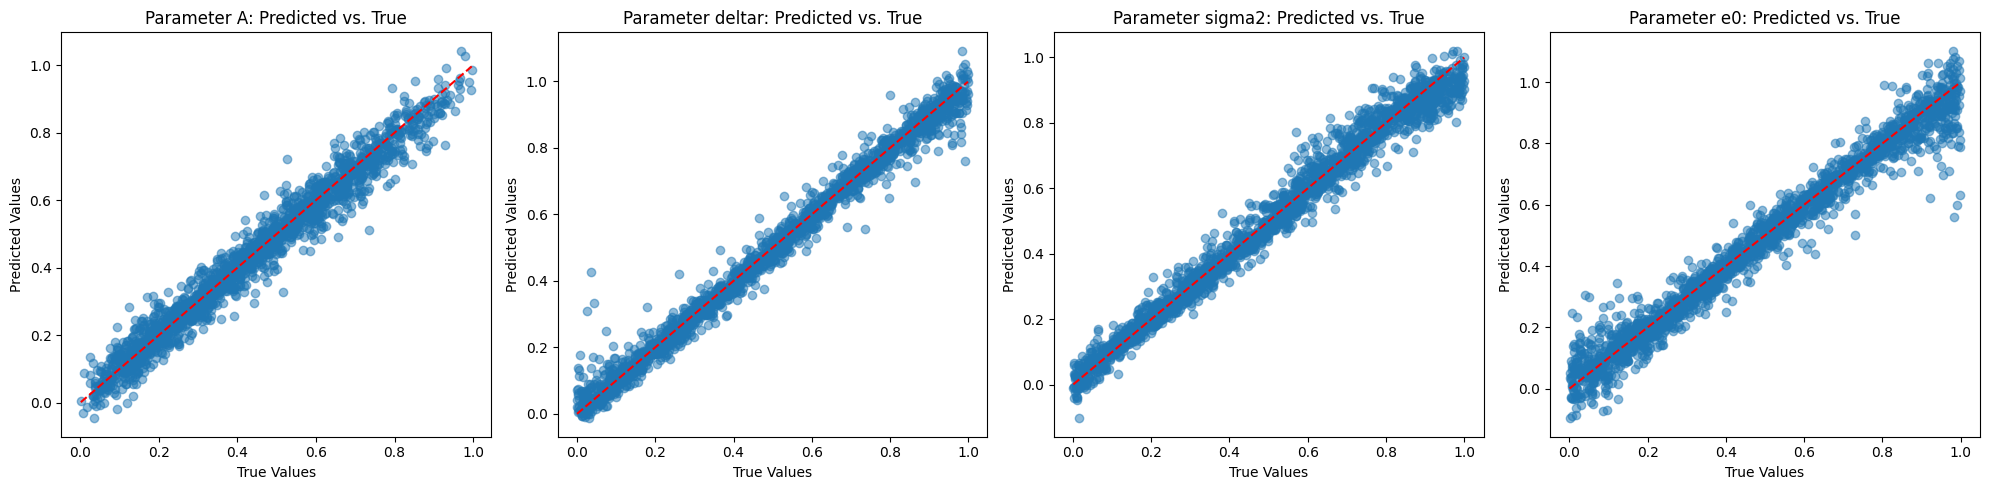

In [20]:
# Predicted vs. True Plots
model.eval()
preds = []
trues = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds.append(outputs.cpu().numpy())
        trues.append(labels.cpu().numpy())

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

# Plot predicted vs. true values for each parameter in a single row
num_parameters = parameters.shape[1]
fig, axs = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 5))

for i in range(num_parameters):
    axs[i].scatter(trues[:, i], preds[:, i], alpha=0.5)
    axs[i].plot(
        [trues[:, i].min(), trues[:, i].max()],
        [trues[:, i].min(), trues[:, i].max()],
        "r--",
    )
    axs[i].set_xlabel("True Values")
    axs[i].set_ylabel("Predicted Values")
    axs[i].set_title(f"Parameter {parameter_name_dict[i]}: Predicted vs. True")

plt.tight_layout()
plt.show()

In [20]:
exp_data_path = "/Users/ryuichi/python/NN_EXAFS/data/Pt/01_predata/sample/sample1/01_foil/Ptfoil.chiq"
pt_data = read_ascii(exp_data_path)
interpolated_exp_chi = interpolate_spectrum(
    pt_data.q, pt_data.chi_re, Synthetic_Generator.k_grid
)

In [ ]:
def predict_and_denormalize(model, interpolated_exp_chi, norm_parameters_params):
    model.eval()
    model

In [21]:
predicted_a, predicted_deltar, predicted_sigma2, predicted_e0 = predict_and_denormalize(
    model, interpolated_exp_chi, norm_parameters_params
)

path_predicted = feffpath(fname)
path_predicted.s02 = 0.94
path_predicted.degen = predicted_a / path_predicted.s02
path_predicted.deltar = path_predicted.reff - predicted_deltar
path_predicted.sigma2 = predicted_sigma2
path_predicted.e0 = predicted_e0
path2chi(path_predicted)

NameError: name 'predict_and_denormalize' is not defined

NameError: name 'path_predicted' is not defined

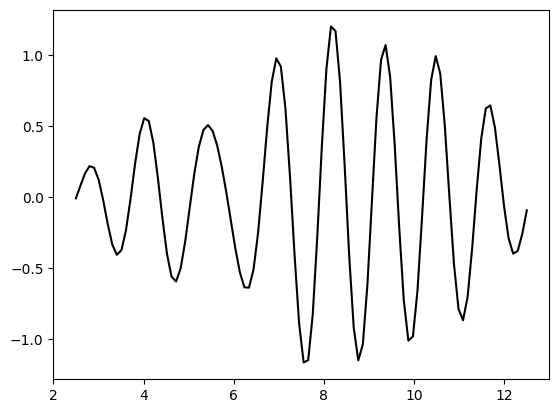

In [22]:
plt.plot(
    Synthetic_Generator.k_grid,
    interpolated_exp_chi,
    label="Experimental",
    color="black",
)
plt.plot(
    path_predicted.k,
    path_predicted.chi * path_predicted.k**2,
    label="Predicted",
    color="red",
)
plt.xlim(2.5, 12.5)
plt.xlabel(r" $ k \rm\, (\AA^{-1})$")
plt.ylabel(r"$ k^2\chi(k)$")
plt.legend()